In [1]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("h:\\Yehmh\\_model\\0514_fine_tune_sam_epoch100.pth"))


# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

c:\Users\user\.conda\envs\RS\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\.conda\envs\RS\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [16]:
import tifffile
from patchify import patchify
import numpy as np

#Apply a trained model on large image
# large_test_image = tifffile.imread("i:\\2024_NDHU research assistant\\DNDF\\202309_大農大富RGB&NDVI\\pix4d file\\006\\006_transparent_mosaic_group1.tif")
# large_test_image = tifffile.imread("i:\\2024_NDHU research assistant\\DNDF\\86_1_clipped_image_2.tiff")
large_test_image = tifffile.imread("h:\\Yehmh\\FuShan\\202403\\202403_rgb.tif")

patches = patchify(large_test_image, (256, 256, 4), step=256)  #Step=256 for 256 patches means no overlap
patches = np.squeeze(patches)
patches = patches[:,:,:,:,:3]
# patches = patches[:,:,:,:3]

# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [17]:
import numpy as np

# Print the shapes of input_points and patches
print(np.array(input_points).shape)
print(patches.shape)

def is_not_mostly_white_or_black(image):
    unique, counts = np.unique(image, return_counts=True)
    pixel_counts = dict(zip(unique, counts))
    total_pixels = image.size // image.shape[-1]  # Dividing by 3 because it's an RGB image
    if pixel_counts.get(255, 0) < 0.9 * total_pixels and pixel_counts.get(0, 0) < 0.9 * total_pixels:
        return True
    return False

# Filter out patches and preserve the structure
patches_tmp = np.empty(patches.shape[:2], dtype=object)

for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patches_tmp[i, j] = [
            patch_img for patch_img in patches[i, j] if is_not_mostly_white_or_black(patch_img)
        ]

# Print progress
total_filtered_patches = sum(len(patch) for patch_row in patches_tmp for patch in patch_row)
print(f"{total_filtered_patches} / {patches.shape[0] * patches.shape[1]}")

# Convert patches_tmp to a numpy array with dtype=object to handle irregular shapes
patches = np.array(patches_tmp, dtype=object)

# Print the shape of the resulting patches array
print("patches shape:", patches.shape)


(1, 1, 100, 2)
(117, 112, 256, 256, 3)
2648610 / 13104
patches shape: (117, 112)


In [38]:
print(np.array(input_points).shape)
print(patches.shape)

# Create a list to store the indices of non-empty masks
valid_indices = [i for i, patch in enumerate(patches) if patch.max() != 0]
patches = patches[valid_indices]
print("patches shape:", patches.shape)  # e.g., (num_frames, height, width, num_channels)

(1, 1, 100, 2)
(116, 112, 256, 256, 3)
patches shape: (116, 112, 256, 256, 3)


In [ ]:
print(np.array(input_points).shape)
print(patches.shape)

# for patch in patches:
#     unique, counts = np.unique(patch, return_counts=True)
#     print(dict(zip(unique, counts)))

def count_pixels(image):
    """
    Count white and black pixels in the image.
    """
    width, height = image.shape[0], image.shape[1]
    white_count = 0
    black_count = 0
    for y in range(height):
        for x in range(width):
            pixel = image[x][y]
            if pixel.all() == 255:  # Assuming white pixels are (255, 255, 255)
                white_count += 1
            elif pixel.all() == 0:       # Assuming black pixels are (0, 0, 0)
                black_count += 1
    return white_count, black_count


for patch in patches:
    patch_tmp = []
    for patch_img in patch:
        white_count, black_count = count_pixels(patch_img)
        print(white_count, black_count)
        total_pixels = array_size * array_size
        if white_count < total_pixels / 2 and black_count < total_pixels / 2:
            patch_tmp.append(patch_img)
            print("append")
    patch = patch_tmp

print("patches shape:", patches.shape)

In [ ]:
print(np.array(input_points).shape)
print(patches.shape)

count = 0
patches_tmp = []
for patch in patches:
    count += 1
    patch_tmp = []
    for patch_img in patch:
        if 0 < max(np.unique(patch_img)) < 255:
            patch_tmp.append(patch_img)
    patches_tmp.append(patch_tmp)
    print(count, "/", patches.shape[0]*patches.shape[1])

patches = np.array(patches_tmp, dtype=object)
print("patches shape:", patches.shape)


In [15]:
import numpy as np

# Print the shapes of input_points and patches
print(np.array(input_points).shape)
print(patches.shape)

def is_not_mostly_white_or_black(image):
    unique, counts = np.unique(image, return_counts=True)
    pixel_counts = dict(zip(unique, counts))
    total_pixels = image.size // image.shape[-1]  # Dividing by 3 because it's an RGB image
    if pixel_counts.get(255, 0) < 0.9 * total_pixels and pixel_counts.get(0, 0) < 0.9 * total_pixels:
        return True
    return False

# Filter out patches
patches_tmp = [
    [patch_img for patch_img in patch if is_not_mostly_white_or_black(patch_img)]
    for patch in patches
]

# Print progress
total_filtered_patches = sum(len(patch) for patch in patches_tmp)
print(f"{total_filtered_patches} / {patches.shape[0] * patches.shape[1]}")

# Convert patches_tmp to a numpy array with dtype=object to handle irregular shapes
patches = np.array(patches_tmp, dtype=object)

# Print the shape of the resulting patches array
print("patches shape:", patches.shape)


(1, 1, 100, 2)
(117, 112, 256, 256, 3)
10314 / 13104
patches shape: (117,)


[[0.72488517 0.78755707 0.67901367 ... 0.62464315 0.6733892  0.65267605]
 [0.8430297  0.9382903  0.8633949  ... 0.9404675  0.9216876  0.88551813]
 [0.8623458  0.952118   0.9286162  ... 0.9510677  0.9364828  0.87969565]
 ...
 [0.6677286  0.96166843 0.8838607  ... 0.87032205 0.81732917 0.7945259 ]
 [0.66550237 0.91938543 0.86504126 ... 0.8001098  0.80034643 0.71316695]
 [0.60494727 0.8787075  0.7666063  ... 0.8145632  0.7582325  0.7412712 ]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


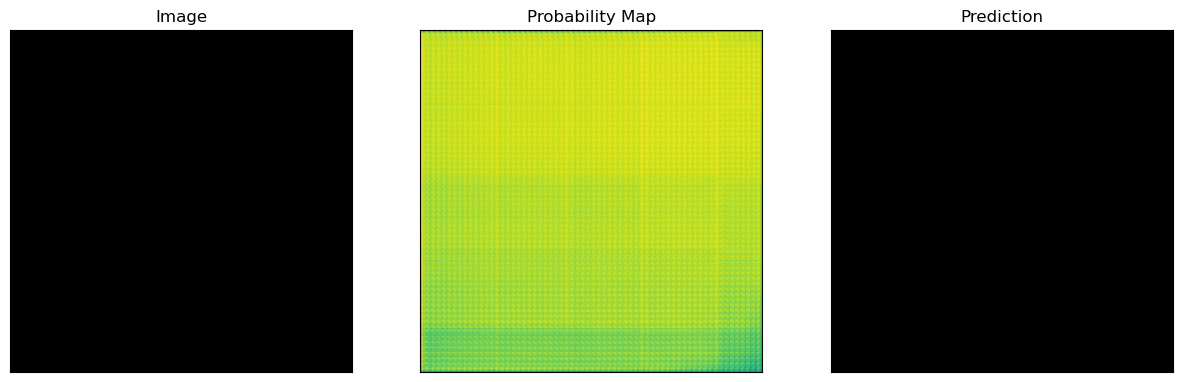

[[0.72488517 0.78755707 0.67901367 ... 0.62464315 0.6733892  0.65267605]
 [0.8430297  0.9382903  0.8633949  ... 0.9404675  0.9216876  0.88551813]
 [0.8623458  0.952118   0.9286162  ... 0.9510677  0.9364828  0.87969565]
 ...
 [0.6677286  0.96166843 0.8838607  ... 0.87032205 0.81732917 0.7945259 ]
 [0.66550237 0.91938543 0.86504126 ... 0.8001098  0.80034643 0.71316695]
 [0.60494727 0.8787075  0.7666063  ... 0.8145632  0.7582325  0.7412712 ]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


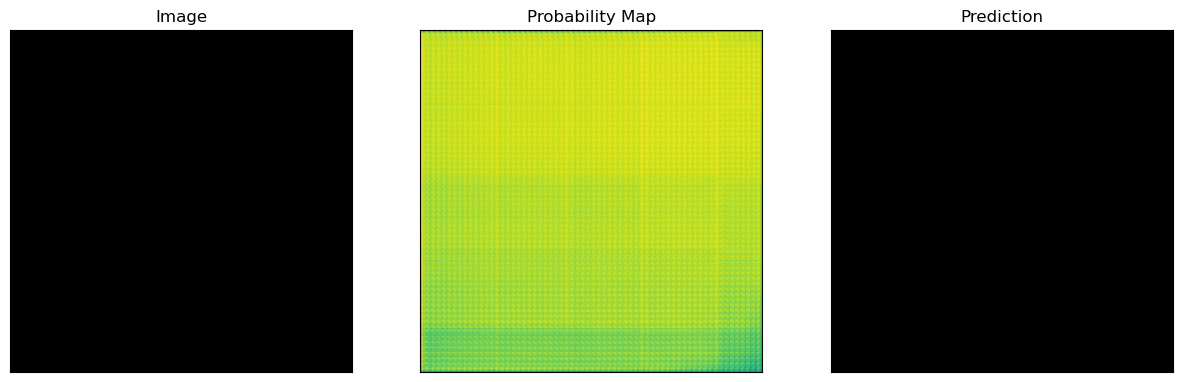

[[0.72488517 0.78755707 0.67901367 ... 0.62464315 0.6733892  0.65267605]
 [0.8430297  0.9382903  0.8633949  ... 0.9404675  0.9216876  0.88551813]
 [0.8623458  0.952118   0.9286162  ... 0.9510677  0.9364828  0.87969565]
 ...
 [0.6677286  0.96166843 0.8838607  ... 0.87032205 0.81732917 0.7945259 ]
 [0.66550237 0.91938543 0.86504126 ... 0.8001098  0.80034643 0.71316695]
 [0.60494727 0.8787075  0.7666063  ... 0.8145632  0.7582325  0.7412712 ]]
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


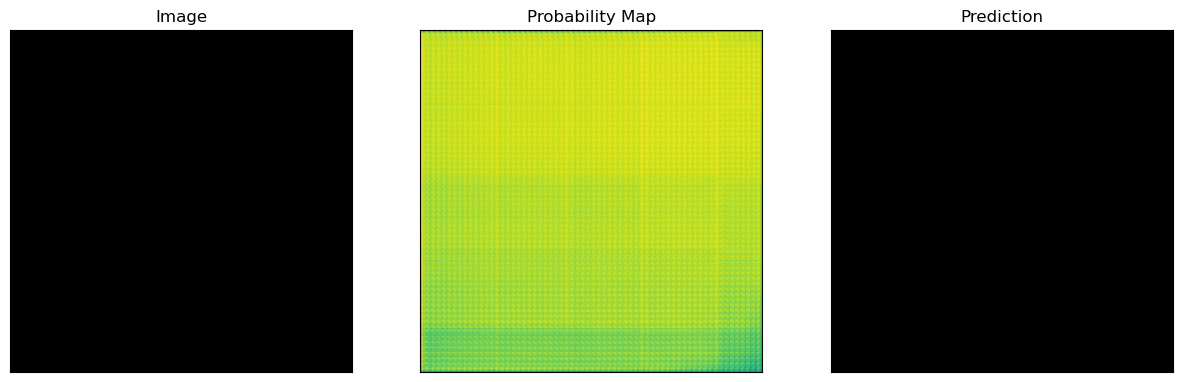

KeyboardInterrupt: 

In [36]:
from PIL import Image
import matplotlib.pyplot as plt

# Select a random patch for segmentation

# # Compute the total number of 256x256 arrays
# num_arrays = patches.shape[0] * patches.shape[1]
# # Select a random index
# index = np.random.choice(num_arrays)
# # Compute the indices in the original array
# i = index // patches.shape[1]
# j = index % patches.shape[1]

#Or pick a specific patch for study.
# i, j = 1, 2

# Selectelected patch for segmentation
# random_array = patches[i, j]

def test(i, j):
  random_array = patches[i, j]

  single_patch = Image.fromarray(random_array)
  # prepare image for the model

  #First try without providing any prompt (no bounding box or input_points)
  inputs = processor(single_patch, return_tensors="pt")
  #Now try with bounding boxes. Remember to uncomment.
  # inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

  # Move the input tensor to the GPU if it's not already there
  inputs = {k: v.to(device) for k, v in inputs.items()}
  my_model.eval()


  # forward pass
  with torch.no_grad():
    outputs = my_model(**inputs, multimask_output=False)

  # apply sigmoid
  single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
  print(single_patch_prob)
  single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)
  print(single_patch_prediction)

  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Plot the first image on the left
  axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
  axes[0].set_title("Image")

  # Plot the second image on the right
  axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
  axes[1].set_title("Probability Map")

  # Plot the second image on the right
  axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
  axes[2].set_title("Prediction")

  # Hide axis ticks and labels
  for ax in axes:
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xticklabels([])
      ax.set_yticklabels([])

  # Display the images side by side
  plt.show()

for i in range(3):
  for j in range(3):
    test(i, j)